In [63]:
import pandas as pd

file_path = "train_without_null.csv"
df = pd.read_csv(file_path)

In [65]:
test_path = "test_without_null.csv"
df_test = pd.read_csv(test_path)

In [66]:
import re

def remove_emoji(text):
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\U00002500-\U00002BEF"  # Chinese char
                        u"\U00010000-\U0010ffff"
                        "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)

In [68]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [69]:
from unidecode import unidecode
import string

def preprocess_review(review):
    preproc_review = review.lower()

    SAD_FACE = [':(', ':c']
    HAPPY_FACE = [':)', ':D']

    for face in SAD_FACE:
        if face in preproc_review:
                preproc_review = preproc_review.replace(face, 'sad')

    for face in HAPPY_FACE:
        if face in review:
                preproc_review = preproc_review.replace(face, 'happy')

    preproc_review = preproc_review.translate(str.maketrans('', '', '0123456789'))
    preproc_review = remove_emoji(preproc_review)
    preproc_review = unidecode(preproc_review)
    preproc_review = decontracted(preproc_review)
    preproc_review = preproc_review.translate(str.maketrans('', '', string.punctuation))

    return preproc_review

In [70]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stem_tokenizer(review):

    review_tokens = word_tokenize(review)

    ps = PorterStemmer()

    return [ps.stem(word) for word in review_tokens]

In [67]:
X_train = df['review_text']
y_train = df['review_score']

X_test = df_test['review_text']
y_test = df_test['review_score']

In [71]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

new_stopwords = stopwords.words('english')
new_stopwords.remove('no')
new_stopwords.remove('not')
new_stopwords.append('becaus')

custom_stopwords = []

for w in new_stopwords:
    custom_stopwords.append(stem_tokenizer(preprocess_review(w))[0])

custom_vect = CountVectorizer(preprocessor=preprocess_review,
                             tokenizer=stem_tokenizer,
                             stop_words=custom_stopwords,
                             max_features=5000)

X_train_vect = custom_vect.fit_transform(X_train)

/mnt/c/Users/bol8clj/Documents/DistributedML_Test/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [72]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

MultinomialNB()

In [74]:
import pickle

with open('testVect.pkl', 'rb') as f:
    X_test_vect = pickle.load(f)

In [73]:
nb.score(X_train_vect, y_train)

0.865711154380804

In [75]:
y_pred = nb.predict(X_test_vect)

Accuracy: 82.01%

F1 Score: 89.93
Precision: 83.35%
Recall: 97.64%


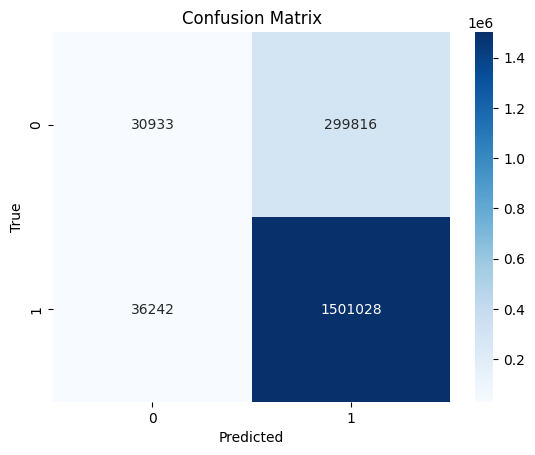

In [76]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix_df1.pdf", format='pdf')
plt.show()

In [77]:
import pickle

with open('trainVect_all.pkl', 'wb') as fout:
    pickle.dump(X_train_vect, fout)

In [78]:
len(df_test[df_test['review_score']==-1])

330749

In [79]:
print(30933/len(df_test[df_test['review_score']==-1]) * 100)

9.352409228750503


In [80]:
print(299816/len(df_test[df_test['review_score']==-1]) * 100)

90.6475907712495
